In [1]:

import sys
sys.path.append('..')


import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

#from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit

import scipy.integrate

from functions_load_stf import *
from functions_end_stf import find_end_stf



In [2]:


combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')


window = 2



In [19]:

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def get_data_and_prepare(row, dataset, get_stf):
	times_to_return = []
	momentrates_to_return = []

	if dataset == 'scardec_moy' or dataset == 'scardec_opt':
		name = row[dataset[:-4]]
	else:
		name = row[dataset]

	if name == '0' or name == 0:
		return None, None

	if dataset == 'scardec_moy':
		momentrate, time = get_stf(name, 'fctmoy')
	elif dataset == 'scardec_opt':
		momentrate, time = get_stf(name, 'fctopt')
	else:
		momentrate, time = get_stf(name)

	if dataset == 'sigloch':
		momentrate_list = momentrate
		time_list = time
	elif dataset == 'isc':
		momentrate_list = momentrate
		time_list = [time]
	else:
		momentrate_list = [momentrate]
		time_list = [time]
		
	count = 0
	for momentrate, time in zip(momentrate_list, time_list):
		if time[0] == time[1]:
			time = time[1:]

		if dataset != 'sigloch':
			save_key = row.event
			dataset_name = dataset
		else:
			dataset_name = dataset + '_' + str(count)
			save_key = row.event + '_' + str(count)

		# if save_key in to_ignore:
		# 	continue
		#print(time[0:10])
		
		momentrate = np.array(momentrate)

		time = np.array(time)


		detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
		time = time[detected_start:detected_end] # shift to start STF at zero
		time = time - time[0]
		print(detected_end)
		print(detected_end_time)
		momentrate = momentrate[detected_start:detected_end]
		#momentrate = momentrate - momentrate[0]
		# max_len = max(max_len, len(momentrate))
		norm_momentrate = momentrate #/ max(momentrate)
		norm_time = time #/ max(time)
		#axs[0].plot(norm_time, norm_momentrate)

		interp_momentrate_stf = np.interp(np.linspace(0, max(time), int(max(time)*100)), norm_time, norm_momentrate)
		#interp_momentrate = np.zeros(20000)
		#if max(time) < 200:
		#	interp_momentrate[0:int(max(time)*100)] = interp_momentrate_stf
		#else:
		#	interp_momentrate = interp_momentrate_stf[0:20000]
		#interp_momentrate[interp_momentrate < 0] = 0
		#print('interp_momentrate', interp_momentrate_stf)
		times_to_return.append(np.linspace(0, max(time), int(max(time)*100)))
		momentrates_to_return.append(interp_momentrate_stf)
	return times_to_return, momentrates_to_return

def peaks_plot_overall(momentrate, momentrate_unsmoothed, time, peaks, name, dataset):
	fig, ax1 = plt.subplots()

	ax2 = ax1.twinx()
	ax1.plot(time, momentrate, 'g-')
	ax2.plot(time, momentrate_unsmoothed, 'k-', alpha=0.5)
	ax1.plot(time[peaks], momentrate[peaks], 'ro')

	ax1.set_xlabel('Time')
	ax1.set_ylabel('Smoothed Moment Rate', color='g')
	ax2.set_ylabel('Unsmoothed Moment Rate', color='k')

	plt.title(f'{name} {dataset}')
	plt.savefig(f'{output_dir}{name}/{dataset}_peaks.png')
	plt.close()


smoothing_param = 10000 # 1/smoothing_param is the fraction of the length of the moment rate to smooth over
r2_limit = 0.95
height_threshold = 0.1 #peaks must be this high

output_dir = f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks_all/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

columns = ['event', 'scardec_opt_max_timing',  'scardec_moy_max_timing', 'ye_max_timing', 'usgs_max_timing', 'sigloch_0_max_timing', 'sigloch_1_max_timing', 'isc_max_timing']
interp_momentrate_sigloch = []
peaks_dict = {}
count_datasets = {}
for i, row in combined.iterrows():
	# if i > 10:
	# 	break
	# 	continue
	print(row.event)
	# if row.event not in ['20011012_1502']:
	# 	continue
	# if i > 100:
	# 	break
	if not os.path.exists(output_dir+f'{row.event}/'):
		os.makedirs(output_dir+f'{row.event}/')
	#with open(f"/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks_all/R2_{r2_limit*10:02}/{row.event}/fits.txt", "w") as file:
	event_dict = {}
	#file.write(f"Processing {row.event}\n")	
	for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):
		#print(dataset)
		if dataset != 'sigloch':
			continue
		times_to_use, momentrates_to_use = get_data_and_prepare(row, dataset, get_stf)
		if times_to_use is None:
			#print('is none')
			continue
		else:
			if dataset not in count_datasets:
				count_datasets[dataset] = 1
			else:
				count_datasets[dataset] += 1
		sigloch_count = 0
		for time, momentrate in zip(times_to_use, momentrates_to_use):
			try:
				if dataset == 'sigloch':
					momentrate = 10**momentrate
					momentrate_sigloch = momentrate.copy()
					#file.write(f'Processing {dataset}_{sigloch_count}\n')
					name_to_save = f'{dataset}_{sigloch_count}'
					# print(name_to_save)
					# print(momentrate[0])
				else:
					#file.write(f'Processing {dataset}\n')
					name_to_save = dataset
				if np.argmax(momentrate) == 0:
					continue
				# plt.plot(time, momentrate)
				# plt.show()
			
				#smoothing_points = len(momentrate) // smoothing_param
				#if smoothing_points == 0:
				#	smoothing_points = 1
				momentrate_unsmoothed = momentrate.copy()
				#momentrate = smooth(momentrate, smoothing_points)
				momentrate = momentrate - momentrate[0]
				max_mr = max(momentrate)
				momentrate = momentrate / 10**int(np.log10(max_mr))

				num_points_below_zero = np.sum(momentrate < 0)
				if num_points_below_zero > 0.1 * len(momentrate):
					continue
				# plt.plot(time, momentrate)
				# plt.show()
				popt_list = []
				r_squared_list = []
				#total_moment = scipy.integrate.simpson(momentrate, dx = time[1]-time[0])
				norm_momentrate = momentrate / max(momentrate)
				norm_time = time / max(time)
				interp_momentrate = np.interp(np.linspace(0, 1, 10000), norm_time, norm_momentrate)
				interp_momentrate[interp_momentrate < 0] = 0
				if dataset == 'sigloch':
					interp_momentrate_sigloch.append(interp_momentrate)
				# plt.plot(np.linspace(0, 1, 10000), interp_momentrate)
				# plt.show()
				# break
				peak_timing = np.argmax(interp_momentrate)

				event_dict[name_to_save + '_max_timing'] = peak_timing

				#peaks_plot_overall(momentrate, momentrate_unsmoothed, time, peaks, row.event, name_to_save)
				#print(f'{dataset} peaks: {num_peaks}')
				if dataset == 'sigloch' and sigloch_count > 0:
					print('sigloch_1')


			except Exception as e:
				print(f'Error: {e}')
				#file.write(f'Error: {e}\n')
				continue
		sigloch_count += 1
	peaks_dict[row.event] = event_dict

# final_df = pd.read_csv(f'{output_dir}peaks_dict.csv', names=columns)
# print(final_df)




20170818_0259
20110126_1542
255
9.97265625
19981010_1629
19920730_0824
19960327_2052
20011012_1502
255
9.972656
255
9.972656
255
9.972656
19960212_0908
20120320_1802
20070402_1202
255
9.972656
20070427_1349
20140904_0533
255
9.97265625
20040715_0427
255
9.972656
255
9.972656
20080415_2259
255
9.97265625
20050505_1912
19940713_1145
20111006_1112
255
9.97265625
20030907_1319
19940713_0235
19980521_2231
20030825_0628
255
9.972656
20060729_1953
20160407_0332
19990508_1944
20181013_1110
20150918_1559
255
9.97265625
20050726_1411
20110915_0800
255
9.97265625
20171031_0042
20171104_0900
20221025_0013
20180814_0329
20211126_0413
20130202_1417
255
9.97265625
20030309_1036
19990119_0335
20011202_0247
19970512_1345
20000126_1326
20120925_2345
255
9.97265625
20190120_0132
20061226_1226
20100630_0722
255
9.97265625
20170428_2023
20151104_0344
255
9.97265625
20200614_1424
20200623_1529
19920804_2108
20080106_0514
20050123_2010
255
9.972656
20020508_1945
20181029_0654
20060102_2213
19990507_1413
2008

In [6]:
t = []
for event in peaks_dict.keys():
	if peaks_dict[event] is None or len(peaks_dict[event]) == 0:
		continue
	else:
		t.append(peaks_dict[event]['sigloch_0_max_timing'])


(array([251., 286., 246., 112.,  33.,   8.,   2.,   2.,   1.,   1.]),
 array([ 202. , 1118.2, 2034.4, 2950.6, 3866.8, 4783. , 5699.2, 6615.4,
        7531.6, 8447.8, 9364. ]),
 <BarContainer object of 10 artists>)

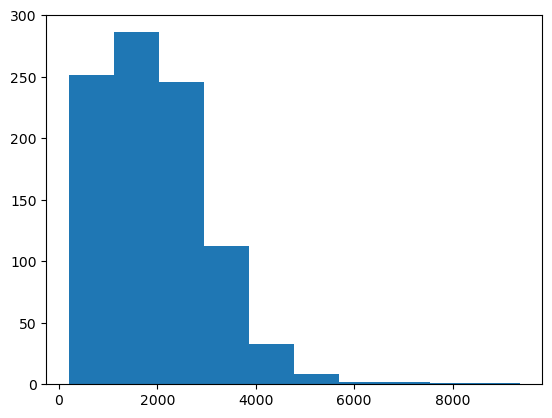

In [7]:
plt.hist(t)

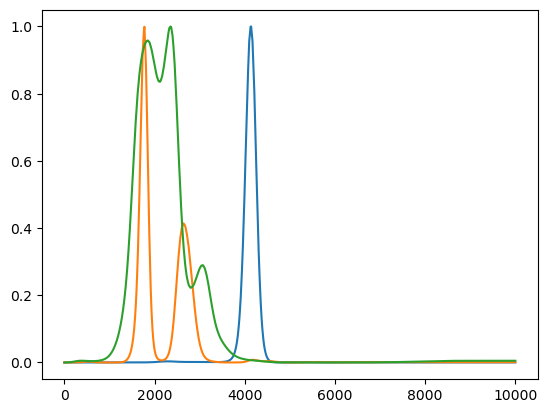

In [13]:
plt.plot(interp_momentrate_sigloch[0])
plt.plot(interp_momentrate_sigloch[1])
plt.plot(interp_momentrate_sigloch[2])

In [16]:
len(np.median(interp_momentrate_sigloch, axis=0))

10000

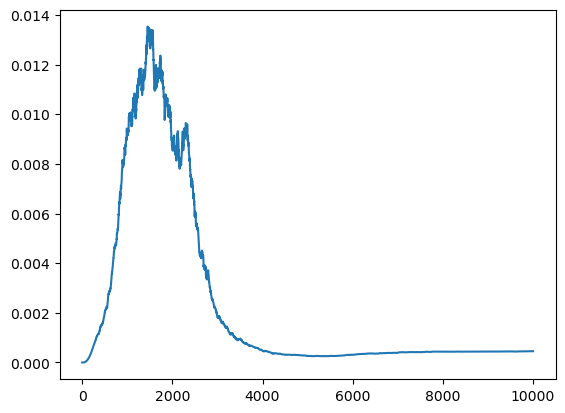

In [17]:
plt.plot(np.median(interp_momentrate_sigloch, axis=0))